In [1]:
#Imports and close()
import numpy as np
from numpy import array as arr
from tkinter import *
import h5py
from abc import ABC, abstractmethod
import copy
import time
import matplotlib as mpl
mpl.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
from matplotlib.figure import Figure
import threading
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# implement the default mpl key bindings
from matplotlib.backend_bases import key_press_handler
mpl.interactive(True)
import traceback
from numpy.polynomial import polynomial as P

def close_all(*args):
    for arg in args:
        arg.close()

# Snake

In [2]:
#Math and consts
from numpy import array, cos, sin, pi, dot
def make_rot_mat(th):
    rot_mat = arr([[cos(th), -sin(th)], 
                     [sin(th), cos(th)]])
    return rot_mat

#Board math
def rel_dist(apple, head):
    return array(apple)-array(head)

def vel_angle(vel):
    return (np.arctan2(vel[1], vel[0])+2*np.pi)%(2*np.pi)

def apple_angle(apple, head):
    rrel_dist = rel_dist(apple, head)
    return (np.arctan2(rrel_dist[1], rrel_dist[0])+2*np.pi)%(2*np.pi)

def rel_angle(apple, head, vel):
    vvel_angle = vel_angle(vel)
    aapple_angle = apple_angle(apple, head)
    return (aapple_angle - vvel_angle+2*np.pi)%(2*np.pi)

def abs_dist(rel_distance):
    return np.sum(np.absolute(rel_distance)) #returns the taxicab distance, as an int

#Colour consts
WALL_C = '#ffffff'
BG_C = '#000000'
APPLE_C = '#33ff00'
HEAD_C = '#8000ff'
HEAD_DEATH_C = '#ff0000'
BODY_C = '#0000ff'

#Other consts
TRANSPOSE = False

GRID_SHAPE = arr([8, 8]) #units: number of cells

In [3]:
#Board 
class Board:
    def __init__(self, rng, shape=(24, 24), apple=np.nan, exc_apple=[]):
        self.shape = shape
        #shape doesnt not exclude outside walls, so the grid is 1 row/col larger than the board on all 4 sides
        self.rng = rng
        #exc_apple is a list of coordinates (resembles player.body)
        self.apple = apple #arbitrary, will be set to something different
        self.set_apple(apple, exc_apple)

    def update(self, player):
        self.set_apple(exc_apple=player.body)

    def export(self):
        grid = np.full((self.shape[0]+2, self.shape[1]+2), WALL_C) #Walls, not displayed on the LED board
        grid[1:-1, 1:-1] = np.full((self.shape[0], self.shape[1]), BG_C) #Background
        grid[self.apple[0], self.apple[1]] = APPLE_C #Apple
        return grid
    
    def set_apple(self, apple=np.nan, exc_apple=[]):
        #Random apple not at specifyied location (usually set to player.body)
        while(np.isnan(apple).all()):
            #The +1 changes the range from 0 to shape[]-1 into from 1 to shape[]
            x = self.rng.randint(self.shape[0])+1
            y = self.rng.randint(self.shape[1])+1
            if [x, y] not in exc_apple:
                apple = [x, y]
        #Check and return set apple
        if 1 <= apple[0] <= self.shape[0] and 0 <= apple[1] <= self.shape[1]:
            self.apple = apple
        else: 
            print("Apple out of bounds at " + str(apple[0]) + ", " + str(apple[1]))

In [4]:
#Player
class Player:
    def __init__(self, rng, start_loc=[1, 1], start_vel=[1, 0]):
        self.body = [start_loc]
        self.vel = array(start_vel) #mvmt vector in the form [xvel, yvel]
        self.age = 0
        self.life_exp = 82
        self.is_alive = True
        self.rng = rng

    def aging(self):
        self.age +=1
    def check_health(self): #Returns true if too old
        if self.age >= self.life_exp:
            #print("Taking too long.")
            return True
        else:
            return False

    def turn(self, dir=0): #0 is straight, -1 is ccw. 1 is cw
        rot_mat = make_rot_mat(dir*pi/2)
        self.vel = dot(rot_mat, self.vel).astype(int)

    def check_collisions(self, board):
        new_head = self.body[0]
        #Walls
        if new_head[0] < 1 or new_head[0] > board.shape[0] or new_head[1] < 1 or new_head[1] > board.shape[1]:
            #print("Wall collision at " + str(new_head[0]) + " " + str(new_head[1]))
            return True
        #Body
        elif new_head in self.body[1:]:
            #print("Body collision at " + str(new_head[0]) + " " + str(new_head[1]))
            return True
        #Nothing
        else:
            return False #Returns true if collides #Returns true if collides with self or wall

    def check_apple(self, board):
        new_head = self.body[0]
        if np.all(new_head == board.apple):
            return True
        else:
            return False

    def dist_obstacle(self, board, dir=0):
        head = self.body[0]
        body = self.body[1:]
        rot_mat = make_rot_mat(dir*pi/2)
        vel = np.rint(dot(rot_mat, self.vel))
        if vel[0] == 1: 
            wall_cells_ahead = [[board.shape[0]+1, head[1]]]
            body_cells_ahead = [cell for cell in body if (cell[0] > head[0] and cell[1] == head[1])]
            cells_ahead = sorted(wall_cells_ahead+body_cells_ahead,key=lambda l:l[0], reverse=False)
        if vel[0] == -1: 
            wall_cells_ahead = [[0, head[1]]]
            body_cells_ahead = [cell for cell in body if (cell[0] < head[0] and cell[1] == head[1])]
            cells_ahead = sorted(wall_cells_ahead+body_cells_ahead,key=lambda l:l[0], reverse=True)
        if vel[1] == 1: 
            wall_cells_ahead = [[head[0], board.shape[1]+1]]
            body_cells_ahead = [cell for cell in body if (cell[1] > head[1] and cell[0] == head[0])]
            cells_ahead = sorted(wall_cells_ahead+body_cells_ahead,key=lambda l:l[1], reverse=False)
        if vel[1] == -1: 
            wall_cells_ahead = [[head[0], 0]]
            body_cells_ahead = [cell for cell in body if (cell[1] < head[1] and cell[0] == head[0])]
            cells_ahead = sorted(wall_cells_ahead+body_cells_ahead,key=lambda l:l[0], reverse=True)
        cell_ahead = cells_ahead[0]
        return abs_dist((rel_dist(cell_ahead, head)))

In [5]:
#Game, Round, and Round.update()
class Game:
    def __init__(self, mode='playback',
                 shape=(24, 24), apple=np.nan, exc_apple=[], 
                 start_loc=[1, 1], start_vel=[1, 0], 
                 rewards_punishments=(80, -10, -10, 5, -2, -1), 
                 transpose=False):
        
        #Immutable variables
        self.mode = mode
        self.rng =  np.random.RandomState(int('game', 36)) #Set the seed to an arbitrary int (I chose a string -> base36)
        self.shape = shape
        #Need to be lists, not tuples, for math and checking if apple not in exc_apple
        if np.isnan(apple): 
            self.start_apple = np.nan
        else: 
            self.start_apple = list(apple)
        self.start_exc_apple = [list(item) for item in exc_apple]
        self.start_loc = list(start_loc)
        self.start_vel = list(start_vel)
        self.rewards_punishments = rewards_punishments
        self.transpose = transpose
        
        #Sets initial roundd, mutable variable
        self.roundd = None
        self.next_round()
        
    @classmethod
    def from_file(cls, filename, mode='playback', apple=np.nan, exc_apple=[], 
                 start_loc=[1, 1], start_vel=[1, 0], transpose=False):
        
        with h5py.File(filename, 'r') as file:
            grid_shape = file.attrs['grid_shape']
            rewards_punishments = file.attrs['rewards_punishments']
        game = Game(mode=mode, shape=grid_shape, apple=apple, exc_apple=exc_apple, 
                 start_loc=start_loc, start_vel=start_vel, rewards_punishments=rewards_punishments)
            
        return game
        
    def next_round(self):
        self.roundd = Round(self.rng, mode=self.mode,
                            shape=self.shape, apple=self.start_apple, exc_apple=self.start_exc_apple, 
                            start_loc=self.start_loc, start_vel=self.start_vel,
                            transpose=self.transpose, rewards_punishments=self.rewards_punishments)
        if self.mode == 'playback': tk_reset_labels()

class Round:
    def __init__(self, rng, mode='playback',
                 shape=(24, 24), apple=np.nan, exc_apple=[], 
                 start_loc=[1, 1], start_vel=[1, 0], 
                 rewards_punishments=(80, -10, -10, 5, -2, -1), 
                 transpose=False):
        
        #Initial values which stay constant
        self.mode = mode
        self.shape = shape
        self.start_apple = apple
        self.start_exc_apple = exc_apple
        self.start_loc = start_loc
        self.start_vel = start_vel
        self.transpose = transpose
        self.rng = rng
        self.rng_start = self.rng.get_state()
        #Reward constants
        (self.APPLE_REWARD, self.COLLISION_PUNISHMENT, self.OLD_AGE_PUNISHMENT, self.CLOSER_REWARD, self.FARTHER_PUNISHMENT, self.SAME_DIST_PUNISHMENT) = rewards_punishments
        
        #First initialization
        self.player = Player(self.rng, start_loc, start_vel)
        exc_apple = self.start_exc_apple + self.player.body #Also don't spawn apple on the player
        self.board = Board(self.rng, self.shape, self.start_apple, exc_apple)
        self.state = (self.player, self.board)
        
        #Score
        self.score = 0
        self.score_update()
        
        self.total_reward = 0
        
    def score_update(self):
        length = len(self.player.body)
        age = self.player.age+1 #Avoids division by zero
        n_cells = self.board.shape[0]*self.board.shape[1]
        self.score = length/age/n_cells
    
    def update(self, turn_dir=0):
        changes = [] #Store boocks to change colour in canvas as [x, y, '#hexhex']
        reward = 0 #Before being set
        
        if self.player.is_alive:
            prev_abs_dist = abs_dist(rel_dist(self.board.apple, self.player.body[0]))

            self.player.turn(turn_dir)

            #Grow one block forward
            self.player.body = [self.player.body[0]] + self.player.body
            #move the new head
            new_head = self.player.body[0]
            new_head = new_head + self.player.vel
            self.player.body[0] = new_head.tolist()
            #Changes
            changes.append([self.player.body[1][0], self.player.body[1][1], BODY_C]) #Previous head becomes a body
            changes.append([self.player.body[0][0], self.player.body[0][1], HEAD_C]) #New head replaces bg

            if self.player.check_apple(self.board):
                #Do not shrink, generate new apple, become youthful again
                self.board.update(self.player)
                self.player.age = 0
                reward = self.APPLE_REWARD
                #Add changes
                new_apple = self.board.apple
                changes.append([new_apple[0], new_apple[1], APPLE_C])
            else:
                #Shrink one block forward
                old_tail = self.player.body.pop(-1)
                #The tail moves away and we see the background again,
                #Second action bc overwrites old head becoming a body (if 1 block long), 
                #              but may be overwritten by head moving in its place
                changes.insert(1, [old_tail[0], old_tail[1], BG_C]) 

            if self.player.check_collisions(self.board):
                #print("DEATH. Length = "+str(len(self.player.body))+", Age = "+str(self.player.age)) 
                self.player.is_alive = False
                reward = self.COLLISION_PUNISHMENT
            self.player.aging()
            if self.player.check_health():
                #print("DEATH. Length = "+str(len(self.player.body))+", Age = "+str(self.player.age)) 
                self.player.is_alive = False
                reward = self.OLD_AGE_PUNISHMENT

            if reward == 0: #If no event
                new_abs_dist = abs_dist(rel_dist(self.board.apple, self.player.body[0]))
                d_dist = new_abs_dist - prev_abs_dist
                if d_dist < 1: reward = self.CLOSER_REWARD
                elif d_dist > 1: reward = self.FARTHER_PUNISHMENT
                else: reward = self.SAME_DIST_PUNISHMENT
                    
            #Death animation
            if self.player.is_alive == False:
                changes.append([self.player.body[0][0], self.player.body[0][1], HEAD_DEATH_C])

            if self.transpose == True: #Flip x and y: [!, ?, '#hexhex'] becomes [?, !, '#hexhex']
                changes = [[change[1], change[0], change[2]] for change in changes]
                
            self.total_reward += reward
            self.score_update()
            
            #Returns, if alive
            if self.mode == 'playback': 
                return tk_update_labels(reward, changes)
            else: 
                return reward, changes
        else: #If dead, do not update tkinter or anything else
            return reward, changes
        
    def retry(self):
        self.rng.set_state(self.rng_start)
        self.player = Player(self.rng, self.start_loc, self.start_vel)
        exc_apple = self.start_exc_apple + self.player.body #Don't spawn apple on the player
        self.board = Board(self.rng, self.shape, self.start_apple, exc_apple)
        self.state = (self.player, self.board)
        
        if self.mode == 'playback': tk_reset_labels()
        
    def export(self):
        b_array = self.board.export()
        for cell in self.player.body:
            b_array[cell[0], cell[1]] = BODY_C #Snake body
        b_array[self.player.body[0][0], self.player.body[0][1]] = HEAD_C #Snake head
        
        if self.transpose: #Swaps first axis with the second (x with y) and vis-versa
            b_array = b_array.T
            
        return b_array.transpose() 

#Tkinter interactions
def tk_update_labels(reward, changes):
    global prev_reward
    prev_reward.set(reward)
    global tot_reward
    tot_reward.set(tot_reward.get()+reward)
    return reward, changes

def tk_reset_labels():
    global prev_reward
    prev_reward.set(0)
    global tot_reward
    tot_reward.set(0)

# Learning

In [6]:
#AI algorithms
class AI(ABC):
    def __init__(self, filename_base, alg=None):
        
        if '_' in filename_base: 
            raise ValueError("".join(["The variable filename_base cannot contain an underscore, ", 
                                "as it will prevent the AI.from_file() method of properly detecting the file's alg.", 
                                "The filename_base you attempted to use is: ", 
                                "''", filename_base, "'.'"]))
        self.alg = alg
        
        #File creation/initialization or retrieval
        self.filename = self.alg+'_'+filename_base+'.hdf5'
        self.file = None #Instantiated soon
        try: #to load an existing file
            self.file = h5py.File(self.filename, 'r+') #read/write, fails if doesn't exist
            self.new = False #So implementations know that they don't need to create datasets (only retrieve)
            print("Loaded "+self.filename)
        except OSError: #create file
            #File
            self.file = h5py.File(self.filename, 'w-') #create, fail if exists
            self.new = True #So implementations know that they need to create datasets (not retrieve)
            print("Created "+self.filename)

        if self.new: #Create groups and datasets
            self.history = self.file.create_group('history')
            self.history.create_dataset('score', (0,), dtype=np.float_, maxshape=(None,))
            self.history.create_dataset('reward', (0,), dtype=np.int_, maxshape=(None,))
        else: #Retrieve groups and datasets
            #History
            self.history = self.file['history']
            #Attributes
            self.file.attrs['filename_base'] = filename_base
            self.file.attrs['alg'] = alg
                
    @classmethod
    def from_file(cls, filename):
        filename_without_ext = filename.split('.')[-2]
        filename_base = filename_without_ext.split('_')[-1]
        alg = '_'.join(filename_without_ext.split('_')[:-1])
        
        if alg == 'q_table':
            with h5py.File(filename, 'r') as file:
                grid_shape = file.attrs['grid_shape']
                rewards_punishments = file.attrs['rewards_punishments']
            ai = Q_Table_AI(filename_base, grid_shape, rewards_punishments)
        else:
            raise ValueError("Unknown algorithm. The method AI.from_file() detected the alg: '"+alg+"'.")
            
        return ai
        
    @abstractmethod
    def choose(self, state):
        pass
    
    def learn(self, prev_state, prev_act, new_state, reward):
        pass
    
    def __train_batch(self, game, start_time, size, batch_i):
        xs = np.empty(shape=(size,)) #Filled each batch
        scores = np.empty(shape=(size,), dtype=np.float_) #Filled each batch
        tot_rews = np.empty(shape=(size,), dtype=np.int_) #Filled each batch
        
        #Learning loop
        for trial_i in range(size):
            #Game learning loop
            game.next_round()
            while(game.roundd.player.is_alive):
                copied_state = copy.deepcopy(game.roundd.state)
                choice = self.choose(copied_state)
                reward, changes = game.roundd.update(choice)
                self.learn(copied_state, choice, game.roundd.state, reward)
            #After a game
            tot_trial_i = batch_i*size + trial_i
            xs[trial_i] = tot_trial_i
            scores[trial_i] = game.roundd.score
            tot_rews[trial_i] = game.roundd.total_reward
            
        #Finish batch
        self.history['score'].resize(len(self.history['score'])+len(scores), axis=0)
        self.history['score'][-len(scores):] = arr(scores)
        self.history['reward'].resize(len(self.history['reward'])+len(tot_rews), axis=0)
        self.history['reward'][-len(tot_rews):] = arr(tot_rews)
        print(self.finish_timing(start_time, tot_trial_i+1)) #the +1 is because counts from 0
        return xs, scores, tot_rews
    
    #Learn for every action in rounds of a defined game, for n_trials number of games, displaying time every batch_size
    def __train_gen(self, game, n_trials, batch_size=None):
        if batch_size == None: batch_size = n_trials
        n_batches = int(n_trials/batch_size)
        #n_trials might not be a multiple of batch_size, if so then extra batch of smaller size 
        batch_size_rem = n_trials%batch_size
        if batch_size_rem != 0: n_batches +=1

        #Training loop
        start_time = self.start_timing()
        for batch_i in range(n_batches):
            if batch_size_rem != 0 and batch_i == n_batches-1: #Possibly different size for last batch
                yield self.__train_batch(game, start_time, batch_size_rem, batch_i)
            else: #Regular batches
                yield self.__train_batch(game, start_time, batch_size, batch_i)
                
    def train(self, game, n_trials, batch_size=None):
        
        if batch_size == None: batch_size = n_trials
        n_batches = int(n_trials/batch_size)
        #n_trials might not be a multiple of batch_size, if so then extra batch of smaller size 
        batch_size_rem = n_trials%batch_size
        if batch_size_rem != 0: n_batches +=1

        #Training loop
        start_time = self.start_timing()
        for batch_i in range(n_batches):
            if batch_size_rem != 0 and batch_i == n_batches-1: #Possibly different size for last batch
                self.__train_batch(game, start_time, batch_size_rem, batch_i)
            else: #Regular batches
                self.__train_batch(game, start_time, batch_size, batch_i)
        
    #No learning, but returns an avg score
    def evaluate(self, game, n_trials):
        #Starting variables
        tot_score = 0
        
        #Total learning loop
        for trial_i in range(n_trials):
                
            #Game learning loop
            while(game.roundd.player.is_alive):
                choice = self.choose(game.roundd.state)
                reward, changes = game.roundd.update(choice)
                
            #After a game
            tot_score += game.roundd.score
            
            if trial_i != n_trials-1: #Unless last round, 
                game.next_round()
            
            avg_score = tot_score/n_trials
        return avg_score
        
    #Other functions
    def h5py_tostring(self, filename, dataname):
        return dataname+" in "+filename
    
    def start_timing(self):
        return time.time()
    def finish_timing(self, start_time, trial_i):
        end_time = time.time()
        tot_time = end_time - start_time
        avg_time = tot_time/trial_i
        rounding = 3 #decimals
        string = ("%s seconds in %s rounds" % (round(tot_time, rounding), trial_i))
        string_avg = ("%s seconds per run" % (round(avg_time, rounding)))
        return string, string_avg
        
    def close(self, verbose=True):
        self.file.close()
        if verbose: print("Closed "+self.filename)

class Random_Walk_AI(AI):
    def __init__(self, filename_base):
        super().__init__(filename_base, alg='random_walk')

    def choose(self, state):
        return np.random.randint(-1, 2)

class Greedy_AI(AI):
    def __init__(filename_base, self):
        super().__init__(filename_base, alg='greedy')

    def choose(self, state):
        player = state[0]
        board = state[1]
        #Checking which direction the apple is situated, and so which direction to turn
        rrel_angle = rel_angle(board.apple, player.body[0], player.vel)
        if rrel_angle == 0:
            return 0
        elif rrel_angle < np.pi:
            return 1
        elif rrel_angle > np.pi:
            return -1
        elif rrel_angle == np.pi: #if directly behind head
            return 1 #chosen by dice roll, guaranteed to be random
        else: 
            print("Direction not chosen.")
            print("rrel_angle = "+str(rrel_angle))

class Q_Table_AI(AI):
    def __init__(self, filename_base, grid_shape, rewards_punishments, rng_start='ai'):
        super().__init__(filename_base, alg='q_table')
        self.grid_shape = grid_shape
        self.rng =  np.random.RandomState(int(rng_start, 36))
        
        #Attributes
        self.file.attrs['grid_shape'] = self.grid_shape
        self.file.attrs['rewards_punishments'] = rewards_punishments
        
        #Q file
        if self.new: #Create q_table
            ini_q_data = self.rng.random_sample((4, #velocities
                                          (self.grid_shape[0]-1)*2+1, (self.grid_shape[0]-1)*2+1, #rel apple locations
                                          self.grid_shape[0], self.grid_shape[0], self.grid_shape[0], #obst distances
                                          3)) #possible actions
            self.q_table = self.file.create_dataset('q_table', data=ini_q_data)
            print("Created "+self.h5py_tostring(self.filename, 'q_table'))
        else: #Read q_table
            self.q_table = self.file['q_table']
            
        #Reward history file
        if self.new: #Create reward_history placeholder
            self.history.create_dataset('reward_history', (0,), dtype='i8', maxshape=(None,))
            print("Created "+self.h5py_tostring(self.filename, 'reward_history'))
        
        self.discount = 1 #because game is deterministic
        self.lr = 1

    #Q functions
    def get_q_state(self, game_state, act=np.NaN):
        player = game_state[0]
        board = game_state[1]

        #Converts from velocity vector into number 0 to 3 representing direction
        vel_x = player.vel[0]
        vel_y = player.vel[1]
        if vel_x == 1:          i_vel = 0 #+x
        elif vel_x == -1:       i_vel = 1 #-x
        elif vel_x == 0: #vertical
            if vel_y == 1:      i_vel = 2 #+y
            elif vel_y ==-1:    i_vel = 3 #-y
            else: i_vel = -1 #Error
        else: i_vel = -1 #Error

        #Converts from -(self.grid_shape-1) to (gird_shape-1) into 0 to (self.grid_shape[0]-1)*2
        rel_apple = rel_dist(board.apple, player.body[0])
        if rel_apple[0] < 0: 
            i_rel_apple_x = rel_apple[0] + (self.grid_shape[0]-1) #from -(self.grid_shape-1) to -1 into 0 to (self.grid_shape-2)
        elif rel_apple[0] > 0: 
            i_rel_apple_x = rel_apple[0] + (self.grid_shape[0]-2) #from 1 to (self.grid_shape-1) into (self.grid_shape-1) to (self.grid_shape-1)*2
        else: 
            i_rel_apple_x = -1 #Error, should never happen
        #Same as above, with y
        if rel_apple[1] < 0: 
            i_rel_apple_y = rel_apple[1] + (self.grid_shape[1]-1) #from -(self.grid_shape-1) to -1 into 0 to (self.grid_shape-2)
        elif rel_apple[1] > 0: 
            i_rel_apple_y = rel_apple[1] + (self.grid_shape[1]-2) #from 1 to (self.grid_shape-1) into (self.grid_shape-1) to (self.grid_shape-1)*2
        else: 
            i_rel_apple_y = -1 #Error, should never happen

        #Convert from 1 to (self.grid_shape) into 0 to (self.grid_shape-1)
        i_dist_obst_l = player.dist_obstacle(board, -1)-1
        i_dist_obst_r = player.dist_obstacle(board, 1)-1
        i_dist_obst_s = player.dist_obstacle(board, 0)-1

        #converts from -1 to 1 into 0 to 2
        i_act = act + 1
        
        if np.isnan(act): #returns q index for all actions
            return (i_vel, i_rel_apple_x, i_rel_apple_y, i_dist_obst_l, i_dist_obst_r, i_dist_obst_s)
        else: #returns q index for a specific action
            return (i_vel, i_rel_apple_x, i_rel_apple_y, i_dist_obst_l, i_dist_obst_r, i_dist_obst_s, i_act)
        
    def get_q(self, game_state, act=np.NaN):
        q_state = self.get_q_state(game_state, act=act)
        return self.q_table[q_state]

    def set_q(self, game_state, act, val):
        q_state = self.get_q_state(game_state, act=act)
        self.q_table[q_state] = val
        
    #AI functions
    def choose(self, game_state):
        poss_q = self.get_q(game_state)
        i_act = poss_q.argmax()
        act = i_act-1 #to change the range back from 0 to 2 into -1 to 1
        return act
        
    def learn(self, prev_game_state, prev_act, new_game_state, reward):
        new_q_val = (1 - self.lr)*self.get_q(prev_game_state, prev_act) + self.lr*(reward + self.discount*np.max(self.get_q(new_game_state)))
        self.set_q(prev_game_state, prev_act, new_q_val)    
        
#To rewrite
class Q_Table_Softmax_AI(Q_Table_AI):
    def __init__(self, game, q_filename="q_table_softmax", rng_start='softmax'):
        super().__init__(game=game, q_filename=q_filename, rng_start=rng_start)
        self.rng =  np.random.RandomState(int('probs', 36))
        
    def choose(self, game_state):
        poss_q = self.get_q(game_state)
        probabilities = softmax(poss_q)
        i_act = self.rng.choice(3, p=probabilities)
        act = i_act-1 #to change the range back from 0 to 2 into -1 to 1
        return act
    
#Other functions
def softmax(vals):
     return np.exp(vals) / np.sum(np.exp(vals))
#Allows to retrieve info from and hdf5 file without creating an ai file to contain it
#Returns succinct_view_of_items, full_items_file
"""def inspect_file(filename):
    try:
        file = h5py.File(filename, 'r+')
        succ_items = []
        items = []

        def get_info(name):
            #list to understand the info at a glance without print large datasets
            succ_items.append([name, str(file[name]), list(file[name].attrs.keys())])

            #list to access data
            if type(file[name]) == h5py._hl.group.Group: #groups becomes strings
                info = [file[name].keys]
            elif type(file[name]) == h5py._hl.dataset.Dataset: #datasets become arrays
                info = array(file[name])
            else: #unknown
                info = file[name]
            items.append([name, info, dict(file[name].attrs)])

        file.visit(get_info)
    except Exception: 
        traceback.print_exc()
    finally:
        file.close()
    
    return succ_items, items"""
a = '' #Negates output, can be deleted no problem

## Experiment

In [7]:
#Experiment setup
game_kwargs = {'mode':'learning', 'shape':GRID_SHAPE-2, 'start_loc':[3, 5], 'transpose':TRANSPOSE}
#Reward order: apple, collision, old, closer, farther, same
rewards_punishments_list = [(80, -10, -10, 5, -2, -1), #original
                            (8, -1, -1, 0.5, -0.2, -0.1), #original/10
                            (8, -10, -10, 1, -1, -0.8), #avoid deaths, don't stay in place, 
                            (8, -5, -4, 0, -1.5, -0.5) #avoid death, don't move away
                           ]
n_tests = len(rewards_punishments_list)

In [10]:
#Train
for i in range(n_tests):
    try:
        rewards_punishments = rewards_punishments_list[i]
        print("Reward_punishment "+str(i)+": "+str(rewards_punishments))
        game = Game(**game_kwargs, rewards_punishments=rewards_punishments)
        ai = Q_Table_AI(filename_base='rptest'+str(i), grid_shape=game_kwargs['shape'], rewards_punishments=rewards_punishments)
        #ai.train(game, 25000, 2500)
        ai.train(game, 25000, 2500)
    except Exception:
        traceback.print_exc()
    finally:
        ai.close()
        print('---------------')
        
print("Done.")

#Qtable and rewhist should be in same file, aka inseperable
#is d_dist == 0 possible?

#Q_Table_AI
#grid_shape = (8, 8): 10525 seconds for 200000 rounds, 0.053 seconds per run on average
#grid_shape = (10, 10): 34466.311 seconds for 400000 rounds, 0.086 seconds per run on average
#grid_shape = (8, 8): 249.262 seconds for 4000 rounds, 0.062 seconds per run with anim_gen_tk
#grid_shape = 
#Q_Table_Softamx_AI
#grid_shape = (10, 10): 41856.234 seconds for 400000 rounds, 0.105 seconds per run on average

Reward_punishment 0: (80, -10, -10, 5, -2, -1)
Loaded q_table_rptest0.hdf5
('110.989 seconds in 2500 rounds', '0.044 seconds per run')
('263.956 seconds in 5000 rounds', '0.053 seconds per run')
('424.992 seconds in 7500 rounds', '0.057 seconds per run')
('590.801 seconds in 10000 rounds', '0.059 seconds per run')
('754.344 seconds in 12500 rounds', '0.06 seconds per run')
('919.849 seconds in 15000 rounds', '0.061 seconds per run')
('1089.975 seconds in 17500 rounds', '0.062 seconds per run')
('1256.027 seconds in 20000 rounds', '0.063 seconds per run')
('1419.84 seconds in 22500 rounds', '0.063 seconds per run')
('1583.411 seconds in 25000 rounds', '0.063 seconds per run')
Closed q_table_rptest0.hdf5
---------------
Reward_punishment 1: (8, -1, -1, 0.5, -0.2, -0.1)
Loaded q_table_rptest1.hdf5
('210.151 seconds in 2500 rounds', '0.084 seconds per run')
('443.248 seconds in 5000 rounds', '0.089 seconds per run')
('677.123 seconds in 7500 rounds', '0.09 seconds per run')
('905.259 secon

In [8]:
#Getting data
score_histories = []
for i in range(n_tests):
    rewards_punishments = rewards_punishments_list[i]
    #print("Reward_punishment "+str(i)+": "+str(rewards_punishments))
    ai = AI.from_file('q_table_rptest'+str(i)+'.hdf5')
    score_histories.append(array(ai.history['score'], dtype=np.float64))
    ai.close(verbose=False)

Loaded q_table_rptest0.hdf5
Loaded q_table_rptest1.hdf5
Loaded q_table_rptest2.hdf5
Loaded q_table_rptest3.hdf5


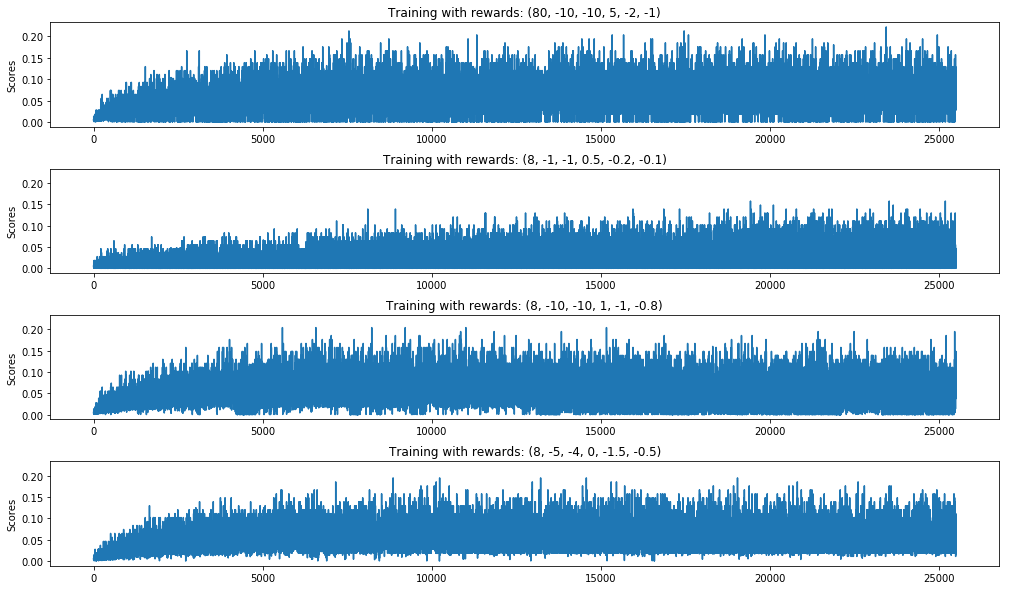

In [9]:
#Plotting score history of each test
%matplotlib inline
fig, axs = plt.subplots(n_tests, 1, sharey=True, figsize=(17, 10))
for i in range(n_tests):
    
    score_history = score_histories[i]
    #For smoothing
    '''batch_size = 50
    n_batches = int(len(tot_rewards)/batch_size)
    ys = np.empty((n_batches,), dtype=int)
    for batch_i in range(n_batches):
        ys[batch_i] = np.mean(tot_rewards[batch_i*batch_size:(batch_i+1)*batch_size])'''
    xs = np.linspace(1, len(score_history), len(score_history))
    ys = score_history
    
    axs[i].plot(xs, ys)
    axs[i].set_title("Training with rewards: "+str(rewards_punishments_list[i]))
    #axs[i].set_xlabel("Batch of size "+str(batch_size))
    axs[i].set_ylabel("Scores")
    
plt.subplots_adjust(hspace=0.4)
plt.show()

#rew_hist = items[0][1][0:2000]
#indices = np.linspace(1, len(rew_hist), len(rew_hist))
#plt.plot(indices, rew_hist)
#plt.show()

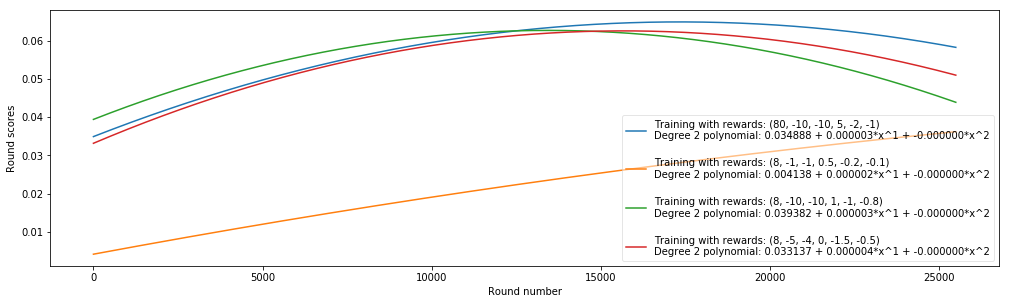

In [10]:
#Score history lines of best fit
%matplotlib inline
fig = plt.figure(figsize=(17, 4.7))
ax = fig.add_subplot(111)

for i in range(n_tests):
    score_history = score_histories[i]
    xs = np.linspace(1, len(score_history), len(score_history))
    ys = score_history
    deg = 2
    coefs = P.polyfit(xs, ys, deg)
    poly = P.Polynomial(coefs)
    
    rewards_str = "Training with rewards: "+str(rewards_punishments_list[i])
    poly_str = "Degree {:d} polynomial: {:f}".format(deg, poly.coef[0]) #degree and smallest order term, scaled
    for j in range(deg): #add terms of increasingly large coef, one at a time
        poly_str = poly_str+" + {:f}*x^{:d}".format(poly.coef[j+1], j+1)
    ax.plot(xs, poly(xs), label=rewards_str+"\n"+poly_str)
    
ax.set_xlabel("Round number")
ax.set_ylabel("Round scores")
leg = plt.legend(loc='best', ncol=1, labelspacing=1.7)
leg.get_frame().set_alpha(0.5)

plt.show()

#rew_hist = items[0][1][0:2000]
#indices = np.linspace(1, len(rew_hist), len(rew_hist))
#plt.plot(indices, rew_hist)
#plt.show()

Loaded q_table_rptest0.hdf5


KeyboardInterrupt: 

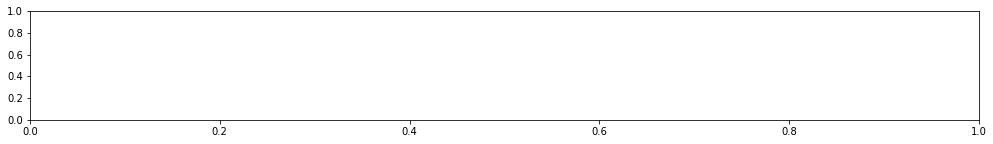

In [11]:
#Get avg after training
%matplotlib inline
fig = plt.figure(figsize=(17, 2))
ax = fig.add_subplot(111)

labels = []
avg_scores = []
for i in range(n_tests):
    try:
        rewards_punishments = rewards_punishments_list[i]
        
        game = Game(**game_kwargs, rewards_punishments=rewards_punishments)
        ai = AI.from_file('q_table_rptest'+str(i)+'.hdf5')
        
        avg_score = ai.evaluate(game, 1000)
        avg_scores.append(avg_score)
        
        ai_name = ("Reward_punishment "+str(i)+": "+str(rewards_punishments))
        score_str = "Average score: {:f}".format(avg_score)
        labels.append(ai_name+"\n"+score_str)
        
    except Exception:
        traceback.print_exc()
    finally:
        ai.close(verbose=False)

xs = np.arange(n_tests)*13
width = fig.get_figwidth()/4
ax.bar(xs, avg_scores, width, align='center')
plt.xticks(xs, labels, rotation=0)

ax.set_title("Q_Table_AIs with different reward_punishments, evaluated over 1000 rounds")
ax.set_ylabel("Average score")

plt.show()

# GUI

In [12]:
#Consts
CELL_SHAPE = arr([40, 40]) #units: pixels

DEATH_DELAY_MULT = 2 #death_delay/delay, so death is noticed more
MIN_DEATH_DELAY = 500 #in milliseconds
MAX_DEATH_DELAY = 1000 #in milliseconds

In [13]:
#Tkinter children
class Game_Canv(Canvas):
    def __init__(self, master=None, grid_shape=[26, 26], cell_shape=[20, 20], **options):
        self.grid_shape = arr(grid_shape) #units: number of cells
        self.cell_shape = arr(cell_shape) #units: pixels
        self.grid_shape_in_px = self.grid_shape*self.cell_shape-2 #The substraction removes a tiny border
        self.cells = np.empty((self.grid_shape[0], self.grid_shape[1]), dtype=int) #Holds the drawn squares
        
        super().__init__(master, width=self.grid_shape_in_px[0], height=self.grid_shape_in_px[1], **options)
        
        
    # Canvas modification functions

    #Clears previous grid and resets it according to a 2d array of '#hexhex' colour strings 
    #Returns a 2d array of each cell (polygon) at the location of the array index
    #Useful for initializing the canvas
    def fill_canvas(self, colour_grid):
        for i in range(self.cells.shape[0]):
            for j in range(self.cells.shape[1]):
                self.cells[i,j] = self.create_polygon(i*self.cell_shape[0], j*self.cell_shape[1], 
                                             (i+1)*self.cell_shape[0], j*self.cell_shape[1], 
                                             (i+1)*self.cell_shape[0], (j+1)*self.cell_shape[1], 
                                             i*self.cell_shape[0], (j+1)*self.cell_shape[1], 
                                             fill=colour_grid[j, i])

    #Changes the colour of each cell according to a colour grid
    def mod_canvas(self, colour_grid):
        for i in range(self.cells.shape[0]):
            for j in range(self.cells.shape[1]):
                self.itemconfig(self.cells[i, j], fill=colour_grid[j, i])

    #Changes the x, y cell to the specified colour
    def mod_item(self, change_lst):
            self.itemconfig(self.cells[change_lst[0], change_lst[1]], fill=change_lst[2])

In [19]:
#Set up tkinter, add labels
def tk_setup_labels(parent_f):
    
    #Stat labels
    stats_f = Frame(parent_f)
    stats_f.pack(side='top')

    prev_reward = IntVar(parent_f)
    prev_reward_str = StringVar(parent_f)
    prev_reward.trace_variable('w', lambda _, __, ___: preceder("Last received reward: ", prev_reward, prev_reward_str))
    prev_reward.set(0)
    prev_reward_lab = Label(stats_f, textvar=prev_reward_str, borderwidth='1px', relief='solid', bg='yellow')
    prev_reward.trace_variable('w', lambda _, __, ___: label_colour_change(prev_reward, prev_reward_lab))
    prev_reward_lab.pack(side='left')

    tot_reward = IntVar(parent_f)
    tot_reward_str = StringVar(parent_f)
    tot_reward.trace_variable('w', lambda _, __, ___: preceder("Total reward: ", tot_reward, tot_reward_str))
    tot_reward.set(0)
    tot_reward_lab = Label(stats_f, textvar=tot_reward_str, borderwidth='1px', relief='solid', bg='#ffff00')
    tot_reward_lab.pack(side='left')
    
    return prev_reward, tot_reward
    
#Preceeds a tkinter variable by some static text and updates a different tkinter variable
def preceder(static_text, tk_old_var, tk_new_var): 
    string = static_text + str(tk_old_var.get())
    tk_new_var.set(string)
#Colours a label bg good or bad depending on sign(variable)
def label_colour_change(tk_var, label): 
    var = tk_var.get()
    if var > 0: label.config(bg="#00ff00")
    elif var < 0: label.config(bg="#ff0000")
    else: label.config(bg="#ffff00")

In [20]:
#Canvas
def tk_setup_canvas(parent_f):
    canv_f = Frame(parent_f)
    canv_f.pack()
    game_canv = Game_Canv(canv_f, grid_shape=GRID_SHAPE, cell_shape=CELL_SHAPE)
    game_canv.pack()
    
    return game_canv

In [21]:
#Buttons
def tk_setup_basic_buttons(parent_f):
    basic_but_f = Frame(parent_f)
    basic_but_f.pack(side='top')
    
    next_act_but = Button(basic_but_f, text="Next action", command=lambda: next_action(game.roundd, playback=autoact_toggle.get()))
    next_act_but.pack(side='left')
    
    def quit_all():
        root.quit()
        root.destroy()
    quit_but = Button(basic_but_f, text="Quit", command=quit_all)
    quit_but.pack(side='left')
    
    retry_round_but = Button(basic_but_f, text="Retry round", command=lambda: retry_round(game.roundd))
    retry_round_but.pack(side='left')
    
    next_round_but = Button(basic_but_f, text="Next round", command=lambda: next_round(game, playback=autoact_toggle.get()))
    next_round_but.pack(side='left')
    
def tk_setup_playback_buttons(parent_f):
    playback_f = Frame(parent_f)
    playback_f.pack(side='top')
    
    
    #Autoact
    autoact_toggle = BooleanVar(parent_f)
    autoact_toggle.set(False)
    def toggle_autoact():
        tog = autoact_toggle.get()
        if tog == True:
            autoact_toggle.set(False)
        elif tog == False:
            autoact_toggle.set(True)
            next_action(game.roundd, playback=True)

    autoact_but = Button(playback_f, text="Toggle autoact", command=toggle_autoact)
    autoact_but.pack(side='left')
    
    
    #Autoround
    autoround_toggle = BooleanVar(parent_f)
    autoround_toggle.set(False)
    def toggle_autoround():
        autoround_toggle.set(not autoround_toggle.get())
        
    autoround_but = Button(playback_f, text="Toggle autoround", command=toggle_autoround)
    autoround_but.pack(side='left')
    
    
    #FPS Entry
    fps_str = StringVar(parent_f)
    fps_str.set('4')
    fps_entry = Entry(playback_f, width=6, textvariable=fps_str)
    
    #Only updates the visualisation speed when enter is pressed, not every time the entry changes
    delay = IntVar(parent_f)
    death_delay = IntVar(parent_f)
    def set_delay(): #Sets regular delay and death delay
        delay.set(int(1000 / int(fps_str.get())))
        new_death_delay = delay.get()*DEATH_DELAY_MULT
        if new_death_delay < MIN_DEATH_DELAY: death_delay.set(MIN_DEATH_DELAY) 
        elif new_death_delay > MAX_DEATH_DELAY: death_delay.set(MAX_DEATH_DELAY)
        else: death_delay.set(new_death_delay)
    set_delay()
    fps_entry.bind('<Return>', lambda event: set_delay())
    fps_entry.pack(side='left')

    
    #return
    return autoact_toggle, autoround_toggle, delay, death_delay
    
def tk_setup_buttons(parent_f):
    but_f = Frame(parent_f)
    but_f.pack(side='bottom')

    tk_setup_basic_buttons(but_f)
    autoact_toggle, autoround_toggle, delay, death_delay = tk_setup_playback_buttons(but_f)
    
    return autoact_toggle, autoround_toggle, delay, death_delay

In [22]:
#Playback
root = Tk()
root.wm_title = "Snake"

#Variable names cannot be changed, used in each other's fns, in the next/retry fns, and in the tk_update/reset_labels fns
prev_reward, tot_reward = tk_setup_labels(root)
game_canv = tk_setup_canvas(root)
autoact_toggle, autoround_toggle, delay, death_delay = tk_setup_buttons(root)

game = Game(mode='playback', shape=GRID_SHAPE-2, start_loc=[3, 5], transpose=TRANSPOSE)
#game = Game.from_file('q_table_rptest0.hdf5', mode='learning', start_loc=[3, 5], transpose=TRANSPOSE)
ai = Q_Table_AI('ttttt', GRID_SHAPE-2, (80, -10, -10, 5, -2, -1))
#ai = AI.from_file('q_table_rptest0.hdf5')

#Init canvas
colour_grid = game.roundd.export()
game_canv.fill_canvas(colour_grid)

#Move once
def next_action(roundd, playback=False):
    action = ai.choose(roundd.state)
    reward, changes = roundd.update(action)
    for change in changes:
        game_canv.mod_item(change)
    if playback: #repeat next_action as long as player is alive
        if roundd.player.is_alive:
            game_canv.after(delay.get(), lambda: next_action(roundd, playback=autoact_toggle.get()))
        elif autoround_toggle.get(): 
            game_canv.after(death_delay.get(), lambda: next_round(game, playback=True))

#New, different round
def next_round(game, playback=False):
    game.next_round()
    colour_grid = game.roundd.export()
    game_canv.mod_canvas(colour_grid)
    if playback:
        game_canv.after(delay.get(), lambda: next_action(game.roundd, playback=autoact_toggle.get()))
    else: return

#Same round, with apple spawning at the same locations
def retry_round(roundd):
    roundd.retry()
    colour_grid = roundd.export()
    game_canv.mod_canvas(colour_grid)

root.mainloop()
close_all(ai)

Created q_table_ttttt.hdf5
Created q_table in q_table_ttttt.hdf5
Created reward_history in q_table_ttttt.hdf5
Closed q_table_ttttt.hdf5


# TODO

Maybe only use tot_reward avgs per batch instead of every tot_reward?
Have canvas size be bigger
Maybe keep q_values between 0 and 1? avoids softmax overflow, but might interfere with initial values being seen as important if uniform
Maybe initialize q values as 0? but first update would make softmax probabilities to \[0.01, 0.01, 0.98\] if reward > 4

Soon, bugfixes:
- be more careful of function inputs (eg what if batch size changes over time)
- succ and items should be flat, not nested
- check if train and train_with_anim work the same way
- remove default q_filename
- When training with anim, first batch waits for the second before being displayed
- q_filename should be name
- which history data should train with tk anim track?

Soon, features:
- Add verbose arg to ai file opening and creating
- q_table_ai should have more info in its files
    * ai files should be openable without reference to game for plotting
    * ai should be able to be generated only by reference to a file
    * q_table should have info about what values are updated (see if stuck or useless values), in what order (maybe learning is too linear), and convergence time (converg_t = n_steps but stops updating when d_value < x%)
- q_table_ai could use improvements
    * saving a list of s, a, r, s', a', r', s", a", ... per batch and apply the updates all at once, which allows to get avg tot_reward per batch_policy, and save some for later experience replay
    * Nonlinearity by starting with snakes of random length, position, and direction
    * q_state should include position (would imply if obstacle is body or wall), length (implies how far along the game is)
    * Explore-exploit in  choose function: get_q(state, act=None), apply softmax to get probabilities from q_values
- better plotting, both intra-batch and inter-batch: mean, variance, std_dev, linear approximation, remove the n maxes and the n mins, etc.
- Make training timing not count rendering?
- Add interesting labels to reward training animation (eg time, avg time)
- Mutually exclusive batch arguments for learning function: 
    * n_batches = n_trials/batch_size, 
    * batch_size = n_trials/n_batches, 
    * batch_time: if time since prev display >= batch_time, then ...
- Save total reward history when training
- Playback mode for vis
    * Speed control for visualization
    * Replay and next trial buttons
    * Save trial as gif
- Learning mode for vis
- All stats collected (pyplot), including realtime plotting of training

Much later, code optimization:
- Merge learning with and without graphing
- why connect to events in train anim
- make ai.q_table_reward_history_data and related variable shorter (for readability)
- Better rng management
- Change abs_dist to accept two points instead of a rel_dist (and call rel_dist on the inputs
- tk_setup fns should not depend oneach other's returns
- Add text to fps_string to remind people to press the enter button (only appears when the values hasn't been fully entered)
- More comprehensive reset function (sets the canvas initially, includes retry from the implementation, etc.)
- Game and round tk interactions go in game_canv or something similar
- Check why sometimes check apple is an array that must use np.any() to collapse truth values
- Remove redundency of cells.shape and grid_shape
- Make the snake an extra layer on top of the board
    * Make it easier to see how the snake turned, instead of simply being a blue block

Much later, increase scope:
- MDP, model based learning
- actor-critic RL
- Test and compare different reward values
- Have q functions turn everything so the player is always facing up
- Have q functions take into account uneven grid shapes (dist_obst_l not always equal to grid_shape\[0\])
- Snake starts at random location with random direction. 
    Problem: apple (board) depends on player, player location depends on board size. 
    Solution:
    * Either with function to initialize player and board together, or
    * exc_apple is removed from board and exc_location is added to player
- Add wall obstacles in the course

Explanation:
- Only 'sees' ahead , to the left, and to the right, but not behid or slightly righ or anything else. So, can't really tell what the rest of its body is doing and if it's trapping itself. Can't add a arr(player.body) to the q_learning table, because it is of variable size, and workarounds (eg nonexistent => -1) would be inefficient in terms of learning and would increase the q_table space by about grid_size\[0\]*grid_size\[1\] dimensions (max number of body parts, 1/cell), each of size about grid_size\[0\]*grid_size\[1\] (max number of cells a certain body part can occupy). 